# Set up

## Magic commands + Imports

In [1]:
# == MAGIC COMMANDS ====================================================================================================
# Enable matplotlib to display graphs directly in the notebook.
%matplotlib inline 

# Load the autoreload extension to automatically reload external Python modules
%load_ext autoreload
%autoreload 2

# Set the precision of floating point numbers displayed in output for better readability
%precision 4


'%.4f'

In [2]:
# ---- Standard Library Imports ----
import gc
import warnings
from pathlib import Path
from typing import Optional

# ---- Third-Party Library Imports ----
import missingno as msno
import mlflow
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
import shap
import matplotlib.pyplot as plt

# ---- Project-Specific Imports ----
# Utilities
from packages.utils import load_csv, check_full_system_environment

# Paths
from packages.constants.paths import PROCESSED_DATA_DIR, MODEL_DIR, ML_FLOW_DIR, ROOT_DIR

# Visualization
from packages.visualization import plot_dtype_distribution, plot_target_distribution

# MLflow Utilities
from packages.mflow_utils import *

# Modelization
from packages.modelisation import *


# Filters
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# To check if automatic garbage collection is enabled or disabled
gc_status = "enabled" if gc.isenabled() else "disabled"
print(f"Garbage collection is currently {gc_status}.")

Garbage collection is currently enabled.


In [4]:
check_full_system_environment()

2025-01-15 14:22:09.413 | INFO     | packages.utils:check_full_system_environment:29 - Starting comprehensive system and GPU environment checks...
2025-01-15 14:22:09.413 | DEBUG    | packages.utils:check_full_system_environment:39 - Python Version: 3.12.4
2025-01-15 14:22:09.413 | DEBUG    | packages.utils:check_full_system_environment:40 - Operating System: Windows 10.0.19045
2025-01-15 14:22:09.429 | DEBUG    | packages.utils:check_full_system_environment:41 - Architecture: AMD64
2025-01-15 14:22:09.430 | DEBUG    | packages.utils:check_full_system_environment:42 - Number of Processors: 16

2025-01-15 14:22:09.463 | INFO     | packages.utils:check_full_system_environment:49 - CUDA nvcc output:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Mon_Oct_24_19:40:05_Pacific_Daylight_Time_2022
Cuda compilation tools, release 12.0, V12.0.76
Build cuda_12.0.r12.0/compiler.31968024_0

2025-01-15 14:22:09.563 | INFO     | packages.utils:check_full_syst

To check the mflow ui, write this inside the terminal :
- `mlflow ui --backend-store-uri "sqlite:///C:/Users/KDTB0620/Documents/Study/Open Classrooms/Git Repository/projet7/ml_flow/ml_flow.db" --default-artifact-root "file:///C:/Users/KDTB0620/Documents/Study/Open Classrooms/Git Repository/projet7/ml_flow/artifacts"`

To run the API:
- `streamlit run <file>

## Loading DataSet

In [5]:
# Loading the training set 
df = load_csv(file_name = "03_df_modelisation_faiss_imputed.csv", parent_path = PROCESSED_DATA_DIR)

# Initial Settings 
df.set_index('SK_ID_CURR', inplace=True)
df['CODE_GENDER_0'] = df['CODE_GENDER_0'].astype(int)

df.rename(columns={
    'DAYS_BIRTH': 'DAYS_SINCE_BIRTH',
    'DAYS_ID_PUBLISH': 'DAYS_SINCE_ID_PUBLISHED',
    'DAYS_REGISTRATION': 'DAYS_SINCE_REGISTRATION',
    'DAYS_LAST_PHONE_CHANGE': 'DAYS_SINCE_LAST_PHONE_CHANGE',
    'CODE_GENDER_0': 'GENDER',
    }, inplace=True)

df.drop(columns=['GENDER'], inplace=True) # INFO: Way too behind in the deadline to deal with this bool variable & SMOTETOmek + it was in the last in feature importance

2025-01-15 14:22:18.280 | INFO     | packages.utils:load_csv:141 - Loaded     03_df_modelisation_faiss_imputed.csv     Shape:     (356251, 53)         Encoding:  ascii


In [ ]:
df.info()

In [ ]:
df

In [ ]:
plot_target_distribution(df)

In [ ]:
msno.matrix(df, labels=True)

In [6]:
# Creating the 2 new dataframes
df_modelisation = df[df['TARGET'].notna()]              # The dataframe meant for Training & Testing
df_predict = df[df['TARGET'].isna()].copy()             # DataFrame for prediction (explicit copy

# Logging
logger.info(f"Original DataFrame shape:         {df.shape}\n")

logger.info(f"Modelisation DataFrame shape:     {df_modelisation.shape} (rows where TARGET != NaN --> Training & Testing)")
logger.info(f"Prediction DataFrame shape:       {df_predict.shape} (rows where TARGET == NaN --> Prediction)\n")

# Cleaning
# del df

2025-01-15 14:22:23.368 | INFO     | __main__:<module>:6 - Original DataFrame shape:         (356251, 51)

2025-01-15 14:22:23.368 | INFO     | __main__:<module>:8 - Modelisation DataFrame shape:     (307507, 51) (rows where TARGET != NaN --> Training & Testing)
2025-01-15 14:22:23.368 | INFO     | __main__:<module>:9 - Prediction DataFrame shape:       (48744, 51) (rows where TARGET == NaN --> Prediction)



In [33]:
#  == Exporting the predict dataframe so it can be requested by the API ================================================

# Dropping the TARGET column
df_predict.drop(columns=['TARGET'], inplace=True)

# Resetting the index as a column
df_predict.reset_index(inplace=True)

# Path
csv_path = PROCESSED_DATA_DIR / "04_prediction_df.csv"

# Saving
df_predict.to_csv(csv_path, index=False)

# Confirm the file creation
if csv_path.exists():
    logger.info(f"Feature importances successfully saved to: {csv_path}")
else:
    logger.error("Error: File was not saved successfully.")


2025-01-14 18:27:13.558 | INFO     | __main__:<module>:17 - Feature importances successfully saved to: C:\Users\KDTB0620\Documents\Study\Open Classrooms\Git Repository\projet7\data\processed\04_prediction_df.csv


In [ ]:
df_predict

# ML FLOW

## Set Up

In [10]:
# == STEP 1: DEFINE & SET PATHS FOR ML FLOW =======================================================================================================
# Ensure the base directory and subdirectories exist
ML_FLOW_DIR.mkdir(parents=True, exist_ok=True)
artifact_path = ML_FLOW_DIR / "artifacts"
artifact_path.mkdir(parents=True, exist_ok=True)

# Log directory setup
logger.info(f"Base Directory Path: {ML_FLOW_DIR}")
logger.info(f"Artifacts Directory: {artifact_path}")

# == STEP 2: SET UP TRACKING & ARTIFACT URIS =====================================================================================================
# Tracking URI for SQLite
tracking_uri = f"sqlite:///{ML_FLOW_DIR}/ml_flow.db"
mlflow.set_tracking_uri(tracking_uri)

# Artifact URI
artifact_uri = f"file:///{artifact_path.as_posix()}"

# Log the URIs
logger.info(f"Tracking URI set to: '{tracking_uri}'")
logger.info(f"Artifact URI set to: '{artifact_uri}'")

# === STEP 3: VERIFY URIS =========================================================================================================================
# Verify the Tracking URI
if mlflow.get_tracking_uri() == tracking_uri:
    logger.success("Tracking URI is correctly configured and functional.")
else:
    logger.error("Tracking URI configuration failed. Please check the settings.")
    raise ValueError("Tracking URI mismatch!")

# Verify the Artifact Path
if artifact_path.is_dir() and artifact_path.exists():
    logger.info(f"Artifact Path verified: {artifact_path}")
else:
    logger.error("Artifact Path verification failed. Ensure the path is accessible.")
    raise ValueError("Artifact Path is invalid!")

2025-01-14 14:58:51.830 | INFO     | __main__:<module>:8 - Base Directory Path: C:\Users\KDTB0620\Documents\Study\Open Classrooms\Git Repository\projet7\ml_flow
2025-01-14 14:58:51.830 | INFO     | __main__:<module>:9 - Artifacts Directory: C:\Users\KDTB0620\Documents\Study\Open Classrooms\Git Repository\projet7\ml_flow\artifacts
2025-01-14 14:58:51.830 | INFO     | __main__:<module>:20 - Tracking URI set to: 'sqlite:///C:\Users\KDTB0620\Documents\Study\Open Classrooms\Git Repository\projet7\ml_flow/ml_flow.db'
2025-01-14 14:58:51.830 | INFO     | __main__:<module>:21 - Artifact URI set to: 'file:///C:/Users/KDTB0620/Documents/Study/Open Classrooms/Git Repository/projet7/ml_flow/artifacts'
2025-01-14 14:58:51.830 | SUCCESS  | __main__:<module>:26 - Tracking URI is correctly configured and functional.
2025-01-14 14:58:51.839 | INFO     | __main__:<module>:33 - Artifact Path verified: C:\Users\KDTB0620\Documents\Study\Open Classrooms\Git Repository\projet7\ml_flow\artifacts


## Manage Experiments

In [ ]:
# === STEP 4: CREATE & MANAGE EXPERIMENTS =========================================================================================================

# === OPTION 1: LIST ALL ACTIVE & DELETED EXPERIMENT ===================================================================
list_all_experiments()

# === OPTION 2: CREATE AN EXPERIMENT ===================================================================================
# The artifact_uri was set up above
experiment_name = "Fine-Tuning Models"
experiment_id = create_experiment(experiment_name, artifact_uri)

# === OPTION 3: DELETE AN ACTIVE EXPERIMENT ============================================================================
#delete_active_experiment(experiment_identifier = '1')

# === OPTION 4: HARD DELETE ALL DELETED EXPERIMENTS ====================================================================
sqlite_db_path: str = f"{ML_FLOW_DIR}/ml_flow.db"
erase_deleted_experiments(sqlite_db_path)

## Manage Models

In [36]:
# === STEP 5: MANAGE EXPERIMENTS ==================================================================================================================

# # === OPTION 1: LIST ALL MODELS & ALL THEIR VERSION ==================================================================
list_all_registered_models_and_versions()

list_all_registered_models_and_versions_with_details()
# === OPTION 2: TRANSITION MODEL STAGE =================================================================================
# transition_model_stage(model_name =  'DummyClassifier - roc_auc', version=1, stage="Staging")
# Possible stages: {"None", "Staging", "Production", "Archived"}

# === OPTION 3: HARD DELETE A MODEL ====================================================================================
#hard_delete_registered_model(model_name = 'LGBMClassifier - roc_auc')

# === OPTION 4: HARD DELETE A SPECIFIC MODEL VERSION ===================================================================
#hard_delete_model_version("MyModelName", version=3)


2025-01-14 13:02:05.095 | INFO     | packages.mflow_utils:list_all_registered_models_and_versions:219 - === LISTING ALL REGISTERED MODELS AND ALL THEIR VERSIONS ===
2025-01-14 13:02:05.116 | SUCCESS  | packages.mflow_utils:list_all_registered_models_and_versions:228 - Model Name ---> 'DummyClassifier - roc_auc'
2025-01-14 13:02:05.128 | DEBUG    | packages.mflow_utils:list_all_registered_models_and_versions:234 -  - Version 2   | Stage: None       | Run ID: a92b27f3872f4d2192ea5c08049471e3    | Description: None
2025-01-14 13:02:05.128 | DEBUG    | packages.mflow_utils:list_all_registered_models_and_versions:234 -  - Version 1   | Stage: None       | Run ID: d4223794b16c4880ba7f5274568dd7c5    | Description: None
2025-01-14 13:02:05.128 | SUCCESS  | packages.mflow_utils:list_all_registered_models_and_versions:228 - Model Name ---> 'LGBMClassifier - business'
2025-01-14 13:02:05.135 | DEBUG    | packages.mflow_utils:list_all_registered_models_and_versions:234 -  - Version 1   | Stage: N

## Tracking

In [ ]:
# TODO: Check how to log the results in a log file !
# ==== LOGGING =========================================================================================================
log_path = Path(ROOT_DIR) / "logs"
log_path.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
temp_log_file = log_path / "mlflow_logs.log"

# Add a temporary file sink to loguru with the same format as the console logs
temp_sink = logger.add(
    temp_log_file,
    level="INFO",
    format="{time:YYYY-MM-DD HH:mm:ss.SSS} | {level:8} | {name}:{function}:{line} - {message}"
)

# Remove the temporary log sink
logger.remove(temp_sink)

# Logging complete, log file written to:
print(f"Logs saved to: {temp_log_file}")

To check the mflow ui, write this inside the terminal :
- `mlflow ui --backend-store-uri "sqlite:///C:/Users/KDTB0620/Documents/Study/Open Classrooms/Git Repository/projet7/ml_flow/ml_flow.db" --default-artifact-root "file:///C:/Users/KDTB0620/Documents/Study/Open Classrooms/Git Repository/projet7/ml_flow/artifacts"`

In [11]:
# === OPTION 1: LIST ALL ACTIVE & DELETED EXPERIMENT ===================================================================
list_all_experiments()

# === TRACKING 1: Set up experiment ====================================================================================
# Artifact_uri can be found in the set up section
experiment_name = "Fine-Tuning Models"
experiment_id = create_experiment(experiment_name, artifact_uri)

# Settings for the ml flow
max_trials = 10 # TODO: set up to 15 knowing that (n_startup_trials = 7 for the TPE)
save_img: bool = True

2025-01-14 14:59:07.372 | SUCCESS  | packages.mflow_utils:list_all_experiments:35 - === ACTIVE EXPERIMENTS ===
2025-01-14 14:59:07.372 | DEBUG    | packages.mflow_utils:list_all_experiments:38 - ID: 2     | Name: Best Model Refined Tuning           | Lifecycle: active
2025-01-14 14:59:07.372 | DEBUG    | packages.mflow_utils:list_all_experiments:38 - ID: 1     | Name: Fine-Tuning Models                  | Lifecycle: active
2025-01-14 14:59:07.380 | SUCCESS  | packages.mflow_utils:list_all_experiments:41 - === DELETED EXPERIMENTS ===
2025-01-14 14:59:07.382 | INFO     | packages.mflow_utils:create_experiment:66 - === CREATING OR RETRIEVING EXPERIMENT ===
2025-01-14 14:59:07.390 | SUCCESS  | packages.mflow_utils:create_experiment:95 - Experiment already exists ---> Fine-Tuning Models        | ID: 1



In [26]:
# === TRACKING 2: INITIALIZE PIPELINE & PREPARE DATA ===================================================================
# Initialize the model pipeline
pipeline = ModelPipeline(mlflow_tracking = True)

# Prepare dataset
X, y = pipeline.prepare_dataset(df = df_modelisation)   # Log X_size, y_size

# Train Test Split
X_train, X_test, y_train, y_test = pipeline.split_data(X, y)

# Adding subset here
X_train_sample, y_train_sample = pipeline.split_data_sample(X, y, train_sample_size = 0.1)

2025-01-14 17:51:39.269 | INFO     | packages.modelisation:__init__:88 - ModelPipeline initialized with:
Random State         | 42
Test Size            | 0.3
MLflow Tracking      | Enabled
2025-01-14 17:51:39.270 | INFO     | packages.modelisation:prepare_dataset:114 - Original DataFrame shape: (307507, 51)
2025-01-14 17:51:39.310 | DEBUG    | packages.modelisation:prepare_dataset:121 - X shape: (307507, 50)
2025-01-14 17:51:39.310 | DEBUG    | packages.modelisation:prepare_dataset:122 - y shape: (307507,)
2025-01-14 17:51:39.322 | INFO     | packages.modelisation:split_data:172 - Starting Data Splitting.
2025-01-14 17:51:39.760 | DEBUG    | packages.modelisation:split_data:207 - Class distribution in training set: {'Class 0 (Repaid)': '91.93% (197877)', 'Class 1 (Not Repaid)': '8.07% (17377)'}
2025-01-14 17:51:39.760 | DEBUG    | packages.modelisation:split_data:208 - Class distribution in testing set: {'Class 0 (Repaid)': '91.93% (84805)', 'Class 1 (Not Repaid)': '8.07% (7448)'}
2025

### DummyClassifier

In [ ]:
# === Model 1: DUMMY CLASSIFIER ============================================================================
with mlflow.start_run(run_name="DummyClassifier (roc_auc)", experiment_id = experiment_id):
    # Set the user tag
    mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

    # Parameters
    model = "DummyClassifier"
    scorer = "roc_auc"

    # Hyperparameter tuning
    best_params, preprocessing_used = pipeline.tune_hyperparameters(X_train_sample, y_train_sample, model=model, scorer=scorer, max_trials=max_trials)

    # Plot optimization history and parameter importance
    pipeline.display_finetuning_results(model_name = model, scorer = scorer, save_img = save_img)

    # Preprocessing
    X_train_processed, y_train_processed, X_test_processed = pipeline.apply_preprocessing(X_train, y_train, X_test, preprocessing_used, return_scaler=False)

    # Fit model
    fitted_model = pipeline.instantiate_fit_model(X_train_processed, y_train_processed, best_params)

    # Save model locally
    model_name = pipeline.save_model_locally(model=fitted_model, scorer=scorer, dir_path=MODEL_DIR)

    # MLFLOW: artifact and registry (optional through registered_model_name)
    pipeline.mlflow_register_model(model=fitted_model, X_train = X_train_processed, registered_model_name = model_name)

    # Evaluation
    pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold=None, scorer=scorer, save_img = save_img)


### Logistic Regression

**WARNING*
While we did takeout one variable from each pair with a colinearity higher than 0.70, we still have many values who possess a high collinearity

Multi collinearity occurs when independent variables in a regression model are highly correlated, undermining the assumption of independence among predictors. This can lead to unstable and unreliable coefficient estimates, making it difficult to assess the unique contribution of each variable to the model. In logistic regression, multi collinearity inflates standard errors, reduces interpretability, and can compromise the model's reliability on new data. Ensuring independent variables minimizes redundancy, improves model stability, and allows for clearer insights into the relationship between predictors and the target outcome.

In [ ]:
# === Model: LOGISTIC REGRESSION ============================================================================
with mlflow.start_run(run_name="LogisticRegression", experiment_id=experiment_id):
    # Set the user tag
    mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

    # === Nested Run 1: LogisticRegression with roc_auc ===
    with mlflow.start_run(run_name="LogisticRegression (roc_auc)", experiment_id=experiment_id, nested=True):
        # Set the user tag
        mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

        model = "LogisticRegression"
        scorer = "roc_auc"

        # Hyperparameter tuning
        best_params, preprocessing_used = pipeline.tune_hyperparameters(X_train_sample, y_train_sample, model=model, scorer=scorer, max_trials=max_trials)

        # Plot optimization history and parameter importance
        pipeline.display_finetuning_results(model_name = model, scorer = scorer, save_img = save_img)

        # Preprocessing
        X_train_processed, y_train_processed, X_test_processed = pipeline.apply_preprocessing(X_train, y_train, X_test, preprocessing_used, return_scaler=False)

        # Fit model
        fitted_model = pipeline.instantiate_fit_model(X_train_processed, y_train_processed, best_params)

        if fitted_model is None:
            mlflow.log_param("model_status", "convergence_failed")
            logger.warning("Skipping evaluation for Logistic Regression due to convergence failure.")
        else:
            # Save model locally
            model_name = pipeline.save_model_locally(model=fitted_model, scorer=scorer, dir_path=MODEL_DIR)

            # MLFLOW: artifact and registry (optional through registered_model_name)
            pipeline.mlflow_register_model(model=fitted_model, X_train = X_train_processed, registered_model_name = model_name)

            # Continue with evaluation and logging
            pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold=None, scorer=scorer, save_img=save_img)

    # # === Nested Run 2: LogisticRegression with business metric ===
    # with mlflow.start_run(run_name="LogisticRegression (business)", experiment_id=experiment_id, nested=True):
    #     model = "LogisticRegression"
    #     scorer = "business"
    #
    #     # Hyperparameter tuning
    #     best_params, preprocessing_used = pipeline.tune_hyperparameters(
    #         X_train_sample, y_train_sample, model=model, scorer=scorer, max_trials=max_trials
    #         )
    #
    #     # Preprocessing
    #     X_train_processed, y_train_processed, X_test_processed = pipeline.apply_preprocessing(
    #         X_train, y_train, X_test, preprocessing_used, return_scaler=False
    #         )
    #
    #     # Fit model
    #     fitted_model = pipeline.instantiate_fit_model(X_train_processed, y_train_processed, best_params)
    #
    #     # Plot optimization history and parameter importance
    #     pipeline.plot_optimization_history(model=model, scorer=scorer, save_img=save_img)
    #     pipeline.plot_param_importance(model=model, scorer=scorer, save_img=save_img)
    #
    #     # Evaluation
    #     pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold=None, scorer=scorer, save_img=save_img)


### LightGBM

In [ ]:
# === Model 2: LIGHTGBM ============================================================================
with mlflow.start_run(run_name="LightGBM", experiment_id=experiment_id):
    # Set the user tag
    mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

    # === Nested Run 1: LightGBM with roc_auc ===
    with mlflow.start_run(run_name="LightGBM (roc_auc)", experiment_id=experiment_id,  nested=True):
        # Set the user tag
        mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

        model = "LightGBM"
        scorer = "roc_auc"

        # Hyperparameter tuning
        best_params, preprocessing_used = pipeline.tune_hyperparameters(X_train_sample, y_train_sample, model=model, scorer=scorer, max_trials=max_trials)

        # Plot optimization history and parameter importance
        pipeline.display_finetuning_results(model_name = model, scorer = scorer, save_img = save_img)

        # Preprocessing
        X_train_processed, y_train_processed, X_test_processed = pipeline.apply_preprocessing(X_train, y_train, X_test, preprocessing_used, return_scaler=False)

        # Fit model
        fitted_model = pipeline.instantiate_fit_model(X_train_processed, y_train_processed, best_params)

        # Save model locally
        model_name = pipeline.save_model_locally(model=fitted_model, scorer=scorer, dir_path=MODEL_DIR)

        # MLFLOW: artifact and registry (optional through registered_model_name)
        pipeline.mlflow_register_model(model=fitted_model, X_train = X_train_processed, registered_model_name = model_name)

        # Evaluation
        pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold=None, scorer=scorer, save_img = save_img)

    # === Nested Run 2: LightGBM with business metric ===
    with mlflow.start_run(run_name="LightGBM (business)", experiment_id=experiment_id, nested=True):
        # Set the user tag
        mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

        model = "LightGBM"
        scorer = "business"

        # Hyperparameter tuning
        best_params, preprocessing_used = pipeline.tune_hyperparameters(X_train_sample, y_train_sample, model=model, scorer=scorer, max_trials=max_trials)

        # Plot optimization history and parameter importance
        pipeline.display_finetuning_results(model_name = model, scorer = scorer, save_img = save_img)

        # Preprocessing
        X_train_processed, y_train_processed, X_test_processed = pipeline.apply_preprocessing(X_train, y_train, X_test, preprocessing_used, return_scaler=False)

        # Fit model
        fitted_model = pipeline.instantiate_fit_model(X_train_processed, y_train_processed, best_params)

        # Save model locally
        model_name = pipeline.save_model_locally(model=fitted_model, scorer=scorer, dir_path=MODEL_DIR)

        # MLFLOW: artifact and registry (optional through registered_model_name)
        pipeline.mlflow_register_model(model=fitted_model, X_train = X_train_processed, registered_model_name = model_name)

        # Evaluation
        pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold=None, scorer=scorer, save_img = save_img)


### XGBoost

In [ ]:
# === XGBOOST  =========================================================================================================
with mlflow.start_run(run_name="XGBoost", experiment_id=experiment_id):
    # Set the user tag
    mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

    # === Nested Run 1: XGBoost with roc_auc ===
    with mlflow.start_run(run_name="XGBoost (roc_auc)", experiment_id=experiment_id, nested=True):
        # Set the user tag
        mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

        model = "XGBoost"
        scorer = "roc_auc"

        # Hyperparameter tuning
        best_params, preprocessing_used = pipeline.tune_hyperparameters(X_train_sample, y_train_sample, model=model, scorer=scorer, max_trials=max_trials)

        # Plot optimization history and parameter importance
        pipeline.display_finetuning_results(model_name = model, scorer = scorer, save_img = save_img)

        # Preprocessing
        X_train_processed, y_train_processed, X_test_processed = pipeline.apply_preprocessing(X_train, y_train, X_test, preprocessing_used, return_scaler=False)

        # Fit model
        fitted_model = pipeline.instantiate_fit_model(X_train_processed, y_train_processed, best_params)

        # Save model locally
        model_name = pipeline.save_model_locally(model=fitted_model, scorer=scorer, dir_path=MODEL_DIR)

        # MLFLOW: artifact and registry (optional through registered_model_name)
        pipeline.mlflow_register_model(model=fitted_model, X_train = X_train_processed, registered_model_name = model_name)

        # Evaluation
        pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold=None, scorer=scorer, save_img=save_img)

    # === Nested Run 2: XGBoost with business metric ===
    with mlflow.start_run(run_name="XGBoost (business)", experiment_id=experiment_id, nested=True):
        # Set the user tag
        mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

        model = "XGBoost"
        scorer = "business"

        # Hyperparameter tuning
        best_params, preprocessing_used = pipeline.tune_hyperparameters(X_train_sample, y_train_sample, model=model, scorer=scorer, max_trials=max_trials)

        # Plot optimization history and parameter importance
        pipeline.display_finetuning_results(model_name = model, scorer = scorer, save_img = save_img)

        # Preprocessing
        X_train_processed, y_train_processed, X_test_processed = pipeline.apply_preprocessing(X_train, y_train, X_test, preprocessing_used, return_scaler=False)

        # Fit model
        fitted_model = pipeline.instantiate_fit_model(X_train_processed, y_train_processed, best_params)

        # Save model locally
        model_name = pipeline.save_model_locally(model=fitted_model, scorer=scorer, dir_path=MODEL_DIR)

        # MLFLOW: artifact and registry (optional through registered_model_name)
        pipeline.mlflow_register_model(model=fitted_model, X_train = X_train_processed, registered_model_name = model_name)

        # Evaluation
        pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold=None, scorer=scorer, save_img=save_img)

### RandomForest

In [ ]:
# === Model 4: RandomForest with nested runs ============================================================================
with mlflow.start_run(run_name="RandomForest", experiment_id=experiment_id):
    # Set the user tag
    mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

    # === Nested Run 1: RandomForest with roc_auc ===
    with mlflow.start_run(run_name="RandomForest (roc_auc)", experiment_id=experiment_id, nested=True):
        # Set the user tag
        mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

        model = "RandomForest"
        scorer = "roc_auc"

        # Hyperparameter tuning
        best_params, preprocessing_used = pipeline.tune_hyperparameters(X_train_sample, y_train_sample, model=model, scorer=scorer, max_trials=max_trials)

        # Plot optimization history and parameter importance
        pipeline.display_finetuning_results(model_name = model, scorer = scorer, save_img = save_img)

        # Preprocessing
        X_train_processed, y_train_processed, X_test_processed = pipeline.apply_preprocessing(X_train, y_train, X_test, preprocessing_used, return_scaler=False)

        # Fit model
        fitted_model = pipeline.instantiate_fit_model(X_train_processed, y_train_processed, best_params)

        # Save model locally
        model_name = pipeline.save_model_locally(model=fitted_model, scorer=scorer, dir_path=MODEL_DIR)

        # MLFLOW: artifact and registry (optional through registered_model_name)
        pipeline.mlflow_register_model(model=fitted_model, X_train = X_train_processed, registered_model_name = model_name)

        # Evaluation
        pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold=None, scorer=scorer, save_img=save_img)

    # === Nested Run 2: RandomForest with business metric ===
    with mlflow.start_run(run_name="RandomForest (business)", experiment_id=experiment_id, nested=True):
        # Set the user tag
        mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

        model = "RandomForest"
        scorer = "business"

        # Hyperparameter tuning
        best_params, preprocessing_used = pipeline.tune_hyperparameters(X_train_sample, y_train_sample, model=model, scorer=scorer, max_trials=max_trials)

        # Plot optimization history and parameter importance
        pipeline.display_finetuning_results(model_name = model, scorer = scorer, save_img = save_img)

        # Preprocessing
        X_train_processed, y_train_processed, X_test_processed = pipeline.apply_preprocessing(X_train, y_train, X_test, preprocessing_used, return_scaler=False)

        # Fit model
        fitted_model = pipeline.instantiate_fit_model(X_train_processed, y_train_processed, best_params)

        # Save model locally
        model_name = pipeline.save_model_locally(model=fitted_model, scorer=scorer, dir_path=MODEL_DIR)

        # MLFLOW: artifact and registry (optional through registered_model_name)
        pipeline.mlflow_register_model(model=fitted_model, X_train = X_train_processed, registered_model_name = model_name)

        # Evaluation
        pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold=None, scorer=scorer, save_img=save_img)

### Results

In [ ]:
pipeline.get_results_df()

In [ ]:
list_all_registered_models_and_versions()

In [ ]:
# === Set stage for the model ===
# Valid stages are : {"None", "Staging", "Production", "Archived"}
version = 1
stage = "Staging"

In [ ]:
from datetime import datetime

# == SAVING DF_RESULTS =================================================================================================

# Get results and prepare file path
df_model_results = pipeline.get_results_df()

temp_path = PROCESSED_DATA_DIR / "models_eval_results.csv"
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d")
temp_path = PROCESSED_DATA_DIR / f"models_eval_results_{timestamp}.csv"


# Export DataFrame to CSV
try:
    df_model_results.to_csv(
        temp_path,
        index=True,
        encoding='utf-8',
        float_format='%.6f'
        )
    logger.info(f"Model results successfully saved to: {temp_path} ({temp_path.stat().st_size} bytes)")
except Exception as e:
    logger.error(f"Error saving file: {e}")

# Best model - LightGBM

## Refined Finetuning

In [27]:
list_all_experiments()

2025-01-14 17:51:53.261 | SUCCESS  | packages.mflow_utils:list_all_experiments:35 - === ACTIVE EXPERIMENTS ===
2025-01-14 17:51:53.291 | DEBUG    | packages.mflow_utils:list_all_experiments:38 - ID: 2     | Name: Best Model Refined Tuning           | Lifecycle: active
2025-01-14 17:51:53.299 | DEBUG    | packages.mflow_utils:list_all_experiments:38 - ID: 1     | Name: Fine-Tuning Models                  | Lifecycle: active
2025-01-14 17:51:53.300 | SUCCESS  | packages.mflow_utils:list_all_experiments:41 - === DELETED EXPERIMENTS ===


In [30]:
list_all_registered_models_and_versions_with_details()

2025-01-14 17:52:08.022 | INFO     | packages.mflow_utils:list_all_registered_models_and_versions_with_details:248 - === LISTING ALL REGISTERED MODELS, VERSIONS, ALIASES, AND TAGS ===
2025-01-14 17:52:08.042 | INFO     | packages.mflow_utils:list_all_registered_models_and_versions_with_details:257 - Model Name ---> 'DummyClassifier - roc_auc'
2025-01-14 17:52:08.051 | DEBUG    | packages.mflow_utils:list_all_registered_models_and_versions_with_details:273 -  - Version 2   | Run ID: a92b27f3872f4d2192ea5c08049471e3         | Description: None
2025-01-14 17:52:08.051 | DEBUG    | packages.mflow_utils:list_all_registered_models_and_versions_with_details:278 -    - Aliases: None
2025-01-14 17:52:08.056 | DEBUG    | packages.mflow_utils:list_all_registered_models_and_versions_with_details:279 -    - Tags: None
2025-01-14 17:52:08.060 | DEBUG    | packages.mflow_utils:list_all_registered_models_and_versions_with_details:273 -  - Version 1   | Run ID: d4223794b16c4880ba7f5274568dd7c5         

In [31]:
# === TRACKING 1: Set up experiment ====================================================================================
# Artifact_uri can be found in the set up section
experiment_name = "Best Model Refined Tuning"
experiment_id = create_experiment(experiment_name, artifact_uri)

2025-01-14 17:52:13.051 | INFO     | packages.mflow_utils:create_experiment:66 - === CREATING OR RETRIEVING EXPERIMENT ===
2025-01-14 17:52:13.064 | SUCCESS  | packages.mflow_utils:create_experiment:95 - Experiment already exists ---> Best Model Refined Tuning | ID: 2



[I 2025-01-14 09:43:09,943] A new study created in memory with name: no-name-c3216c84-09a3-41bf-a3b4-69c66c233fde
2025-01-14 09:44:48.375 | INFO     | packages.modelisation:lightgbm_objective:1050 - Trial 0: Score = -8318.8886, Scorer = make_scorer(business_cost, response_method='predict')
2025-01-14 09:44:48.459 | INFO     | packages.modelisation:lightgbm_objective:1062 - GPU ID: 0, Name: NVIDIA T1200 Laptop GPU, Load: 30.0%, Memory: 537.0MB/4096.0MB
[I 2025-01-14 09:44:48,463] Trial 0 finished with value: -8318.888624087382 and parameters: {'num_leaves': 35, 'n_estimators': 1441, 'lambda_l2': 0.09454306819536169, 'feature_fraction': 0.679597545259111, 'learning_rate': 0.01624074561769746, 'min_child_samples': 35, 'sampling_strategy': 0.25}. Best is trial 0 with value: -8318.888624087382.
2025-01-14 09:45:36.403 | INFO     | packages.modelisation:lightgbm_objective:1050 - Trial 1: Score = -5715.1961, Scorer = make_scorer(business_cost, response_method='predict')
2025-01-14 09:45:36.48

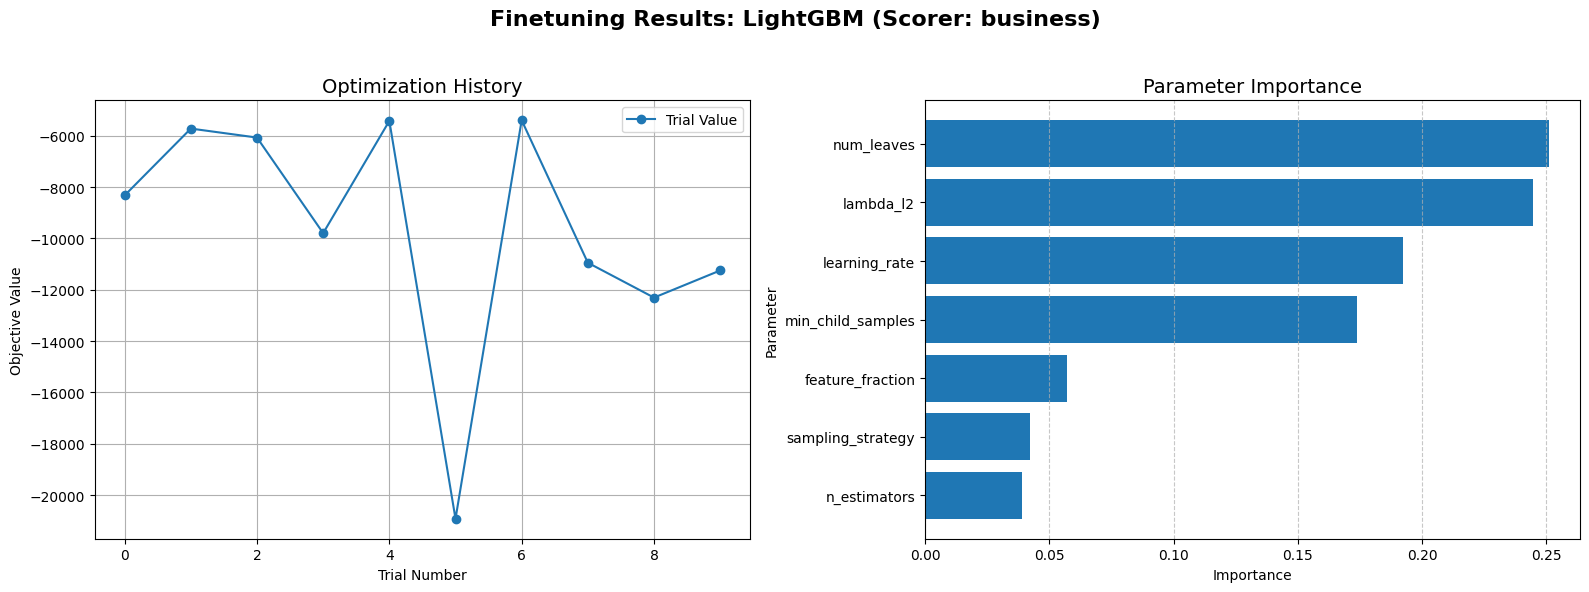

2025-01-14 09:52:52.304 | INFO     | packages.modelisation:apply_preprocessing:323 - Starting preprocessing with the following settings: {'preprocessing_used': {'sampler': 'SMOTETomek', 'sampling_strategy': 0.35, 'scaling': [{'type': 'RobustScaler', 'parameters': {}}], 'custom_smote': {'sampling_strategy': 0.35}, 'custom_tomek': {'sampling_strategy': 'majority'}}}
2025-01-14 09:52:52.435 | DEBUG    | packages.modelisation:apply_preprocessing:336 - Passthrough features: []
2025-01-14 09:52:53.045 | DEBUG    | packages.modelisation:apply_preprocessing:370 - Numeric features scaled successfully.
2025-01-14 09:52:53.136 | DEBUG    | packages.modelisation:apply_preprocessing:379 - Columns reordered to match original structure.
2025-01-14 09:54:48.618 | SUCCESS  | packages.modelisation:apply_preprocessing:389 - Resampling completed successfully.
2025-01-14 09:54:48.644 | SUCCESS  | packages.modelisation:save_scaler:1141 - Scaler saved locally at: C:\Users\KDTB0620\Documents\Study\Open Classr

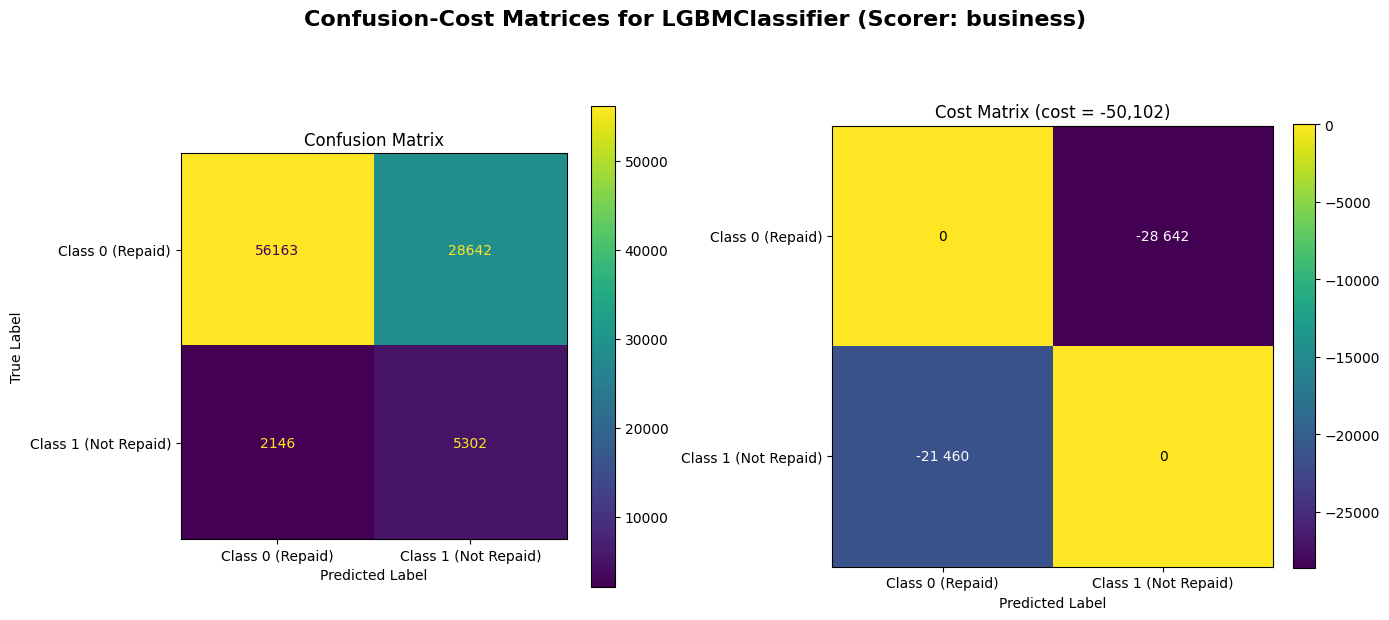

2025-01-14 09:55:42.077 | INFO     | packages.modelisation:threshold_evaluation_cost:1764 - Starting threshold evaluation.
2025-01-14 09:55:43.094 | DEBUG    | packages.modelisation:threshold_evaluation_cost:1785 - Threshold: 0.00, Cost: -84805.00, FP: 84805, FN: 0
2025-01-14 09:55:43.145 | DEBUG    | packages.modelisation:threshold_evaluation_cost:1785 - Threshold: 0.01, Cost: -84805.00, FP: 84805, FN: 0
2025-01-14 09:55:43.184 | DEBUG    | packages.modelisation:threshold_evaluation_cost:1785 - Threshold: 0.02, Cost: -84802.00, FP: 84802, FN: 0
2025-01-14 09:55:43.233 | DEBUG    | packages.modelisation:threshold_evaluation_cost:1785 - Threshold: 0.03, Cost: -84760.00, FP: 84760, FN: 0
2025-01-14 09:55:43.277 | DEBUG    | packages.modelisation:threshold_evaluation_cost:1785 - Threshold: 0.04, Cost: -84635.00, FP: 84635, FN: 0
2025-01-14 09:55:43.335 | DEBUG    | packages.modelisation:threshold_evaluation_cost:1785 - Threshold: 0.05, Cost: -84356.01, FP: 84336, FN: 2
2025-01-14 09:55:43

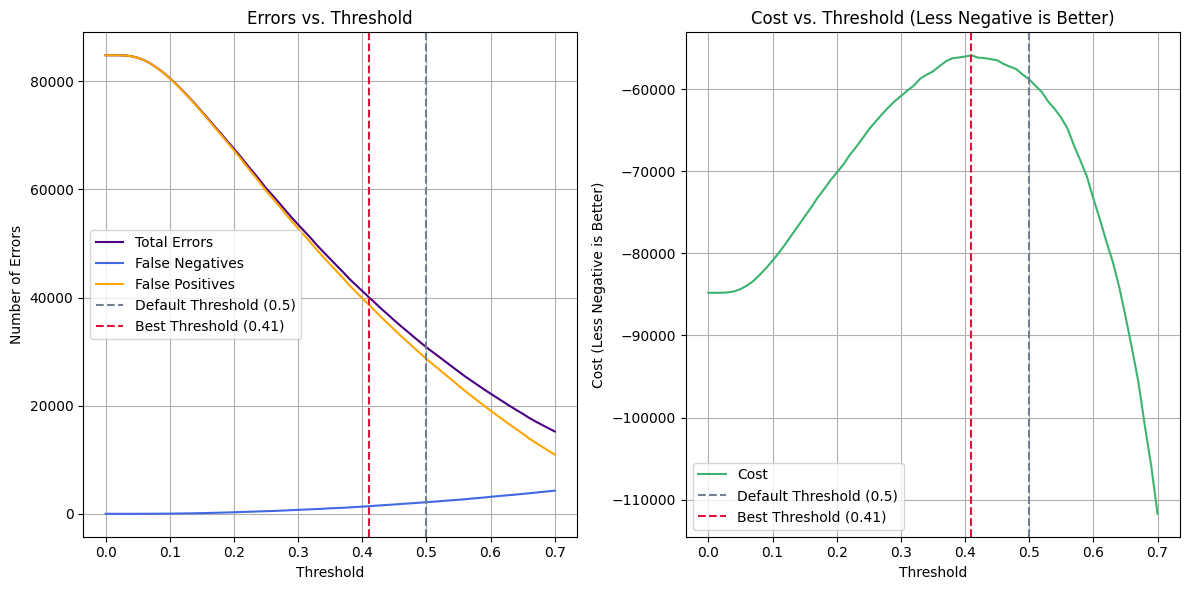

2025-01-14 09:55:47.737 | INFO     | packages.modelisation:model_evaluation:1600 - Evaluating model 'LGBMClassifier' with custom threshold = 0.41000000000000003.
2025-01-14 09:55:47.885 | DEBUG    | packages.modelisation:model_evaluation:1615 - Standardized Business Cost for threshold (0.41000000000000003):
TN: 46106, FP: 38699
FN: 1395, TP: 6053
Profit: 66,040     | Cost: -52,649    | Standardized Cost: 0.71
2025-01-14 09:55:47.927 | SUCCESS  | packages.modelisation:model_evaluation:1640 - Classification Report for 'LGBMClassifier' with threshold = 0.41000000000000003:
                      precision    recall  f1-score   support

    Class 0 (Repaid)       0.97      0.54      0.70     84805
Class 1 (Not Repaid)       0.14      0.81      0.23      7448

            accuracy                           0.57     92253
           macro avg       0.55      0.68      0.46     92253
        weighted avg       0.90      0.57      0.66     92253

2025-01-14 09:55:48.327 | SUCCESS  | packages.mo

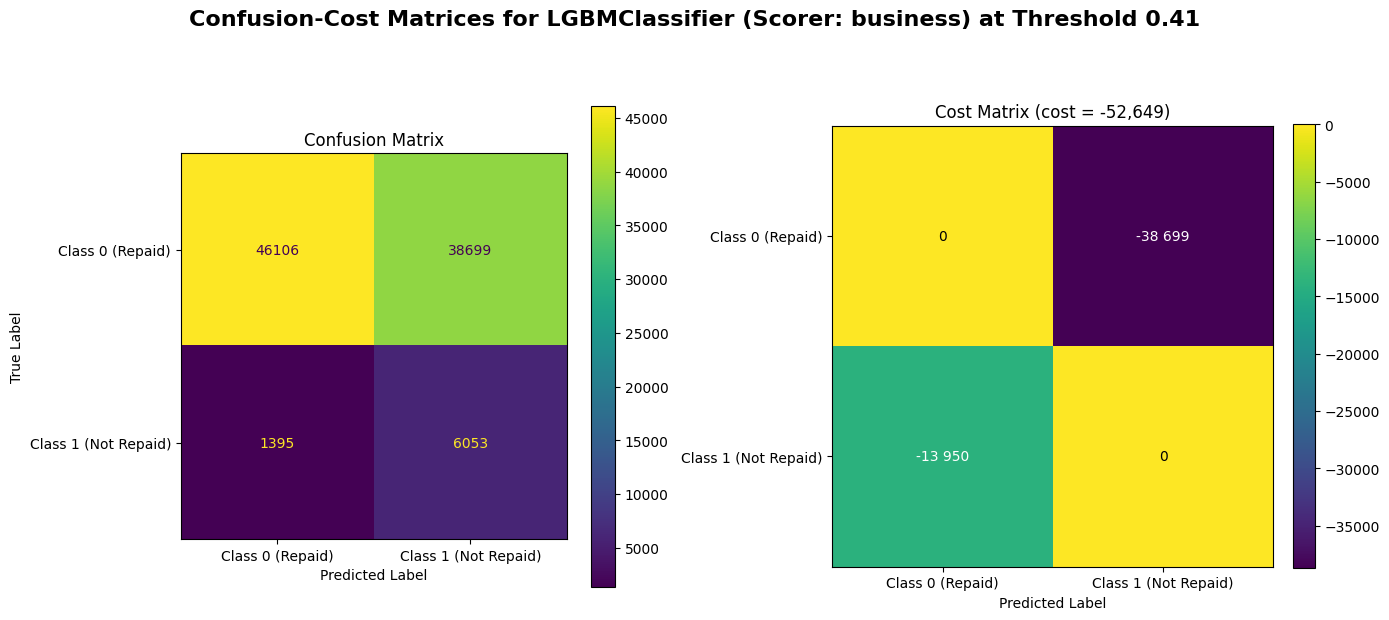

In [24]:
# === LIGHTGBM =========================================================================================================
with mlflow.start_run(run_name="LightGBM Tuning", experiment_id=experiment_id):
    # Set the user tag
    mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")

    # Parameters
    model = "LightGBM"
    scorer = "business"
    max_trials = 10 # TODO: set it up to 30 for final use
    save_img = True

    # Hyperparameter tuning
    best_params, preprocessing_used = pipeline.refined_lightgbm_tuning(X_train_sample, y_train_sample, max_trials=max_trials)

    # Plot optimization history and parameter importance
    pipeline.display_finetuning_results(model_name = model, scorer = scorer, save_img = save_img)

    # Preprocessing
    X_train_processed, y_train_processed, X_test_processed, robust_scaler = pipeline.apply_preprocessing(X_train, y_train, X_test, preprocessing_used, return_scaler=True)

    # Saving the scaler
    pipeline.save_scaler(scaler = robust_scaler, dir_path = MODEL_DIR, log_to_mlflow = True)

    # Fit model
    fitted_model = pipeline.instantiate_fit_model(X_train_processed, y_train_processed, best_params)

    # Save model locally
    model_name = pipeline.save_model_locally(model=fitted_model, scorer=scorer, dir_path=MODEL_DIR)

    # MLFLOW: artifact and registry (optional through registered_model_name)
    pipeline.mlflow_register_model(model=fitted_model, X_train = X_train_processed, registered_model_name = model_name)

    # === Nested Run 1: Evaluation with Default Threshold ===
    with mlflow.start_run(run_name = "Default Threshold Evaluation", experiment_id=experiment_id, nested=True):
        mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")
        pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold=None, scorer=scorer, save_img = save_img, log_to_mlflow = True)

    # === Nested Run 2: Evaluation with Best Threshold ===
    with mlflow.start_run(run_name = "Custom Threshold Evaluation", experiment_id=experiment_id,  nested=True):
        mlflow.set_tag("mlflow.user", "Ovidiu PASCAL")
        best_threshold = pipeline.threshold_evaluation_cost(fitted_model, X_test_processed, y_test)
        pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold=best_threshold, scorer=scorer, save_img = save_img, log_to_mlflow = True)

In [25]:
pipeline.get_results_df()

,Model,Scorer,Threshold,Precision,Recall,FNR,F2 Score,ROC-AUC,FN,FP,Cost,Profit,Business Cost Std
0,LGBMClassifier,business,0.41,0.135257,0.812701,0.187299,0.406002,0.752068,1395,38699,-52649,66040,0.710648
1,LGBMClassifier,business,0.50,0.156198,0.711869,0.288131,0.415934,0.752068,2146,28642,-50102,136570,0.668506


In [17]:
import mlflow
print(mlflow.__version__)


client = MlflowClient()
model_version = client.get_model_version_by_alias("LGBMClassifier - business", alias="champion")
print(model_version)


2.19.0
<ModelVersion: aliases=['champion'], creation_timestamp=1736844940243, current_stage='None', description='Finetuned model to be put in production', last_updated_timestamp=1736863179447, name='LGBMClassifier - business', run_id='6574f1556be94f16b078c11a54468d28', run_link=None, source=('file:///C:/Users/KDTB0620/Documents/Study/Open Classrooms/Git '
 'Repository/projet7/ml_flow/artifacts/6574f1556be94f16b078c11a54468d28/artifacts/model'), status='READY', status_message=None, tags={'business_cost_std': '0.71',
 'custom_threshold': '0.46',
 'environment': 'production'}, user_id=None, version=1>


In [20]:
tags = {
    "environment": "production",
    "custom_threshold": best_threshold,
    "business_cost_std": 0.71
    }

mlflow_set_alias_tags_and_description(
    registered_model_name = 'LGBMClassifier - business',
    version = 1,
    alias = 'champion',
    tags = tags,
    description = "Finetuned model to be put in production"
)

list_all_registered_models_and_versions_with_details()

2025-01-14 15:26:55.496 | INFO     | packages.mflow_utils:mlflow_set_alias_tags_and_description:301 - LGBMClassifier - business | Version 1         
2025-01-14 15:26:55.505 | SUCCESS  | packages.mflow_utils:mlflow_set_alias_tags_and_description:305 -     - Assigned alias @'champion'
2025-01-14 15:26:55.518 | SUCCESS  | packages.mflow_utils:mlflow_set_alias_tags_and_description:312 -     - Added tags: {'environment': 'production', 'custom_threshold': 0.46, 'business_cost_std': 0.71}
2025-01-14 15:26:55.525 | SUCCESS  | packages.mflow_utils:mlflow_set_alias_tags_and_description:321 -     - Added description: 'Finetuned model to be put in production'
2025-01-14 15:26:55.525 | INFO     | packages.mflow_utils:list_all_registered_models_and_versions_with_details:248 - === LISTING ALL REGISTERED MODELS, VERSIONS, ALIASES, AND TAGS ===
2025-01-14 15:26:55.544 | INFO     | packages.mflow_utils:list_all_registered_models_and_versions_with_details:257 - Model Name ---> 'DummyClassifier - roc_auc'

## Threshold through profit

2025-01-14 09:56:27.735 | INFO     | packages.modelisation:threshold_evaluation_profit:1842 - Starting threshold evaluation.
2025-01-14 09:56:28.905 | DEBUG    | packages.modelisation:threshold_evaluation_profit:1876 - Threshold: 0.00, Profit: -339220, FP: 84805, FN: 0
2025-01-14 09:56:29.011 | DEBUG    | packages.modelisation:threshold_evaluation_profit:1876 - Threshold: 0.01, Profit: -339220, FP: 84805, FN: 0
2025-01-14 09:56:29.112 | DEBUG    | packages.modelisation:threshold_evaluation_profit:1876 - Threshold: 0.02, Profit: -339190, FP: 84802, FN: 0
2025-01-14 09:56:29.225 | DEBUG    | packages.modelisation:threshold_evaluation_profit:1876 - Threshold: 0.03, Profit: -338770, FP: 84760, FN: 0
2025-01-14 09:56:29.347 | DEBUG    | packages.modelisation:threshold_evaluation_profit:1876 - Threshold: 0.04, Profit: -337520, FP: 84635, FN: 0
2025-01-14 09:56:29.472 | DEBUG    | packages.modelisation:threshold_evaluation_profit:1876 - Threshold: 0.05, Profit: -334610, FP: 84336, FN: 2
2025-

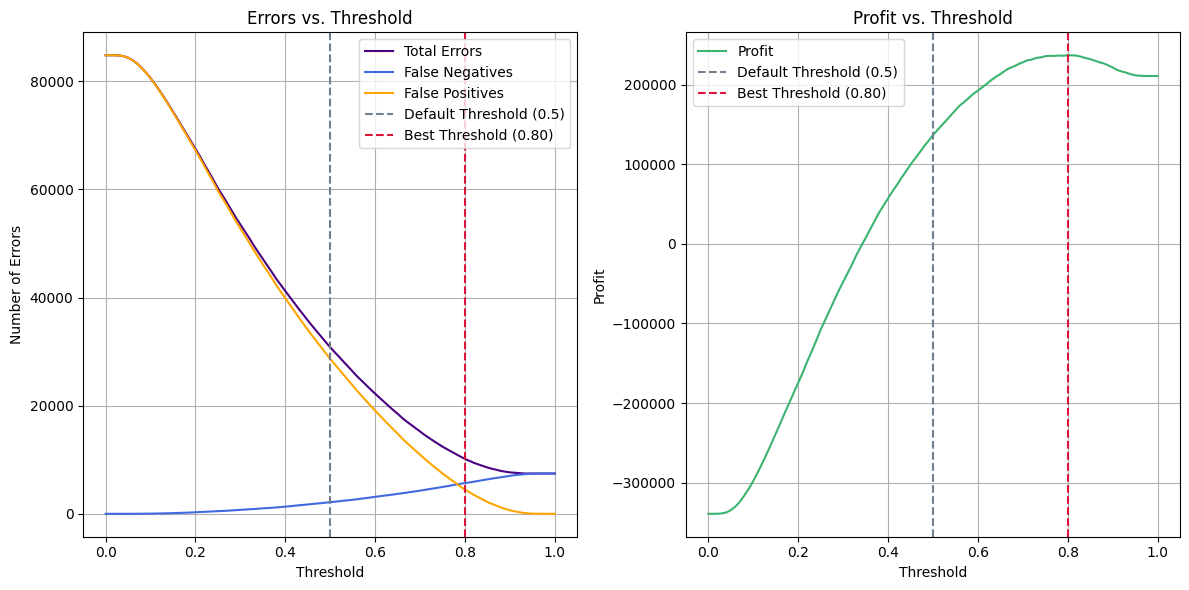

2025-01-14 09:56:41.018 | INFO     | packages.modelisation:model_evaluation:1600 - Evaluating model 'LGBMClassifier' with custom threshold = 0.8.
2025-01-14 09:56:41.170 | DEBUG    | packages.modelisation:model_evaluation:1615 - Standardized Business Cost for threshold (0.8):
TN: 80346, FP: 4459
FN: 5681, TP: 1767
Profit: 237,000    | Cost: -61,269    | Standardized Cost: 0.20
2025-01-14 09:56:41.227 | SUCCESS  | packages.modelisation:model_evaluation:1640 - Classification Report for 'LGBMClassifier' with threshold = 0.8:
                      precision    recall  f1-score   support

    Class 0 (Repaid)       0.93      0.95      0.94     84805
Class 1 (Not Repaid)       0.28      0.24      0.26      7448

            accuracy                           0.89     92253
           macro avg       0.61      0.59      0.60     92253
        weighted avg       0.88      0.89      0.89     92253



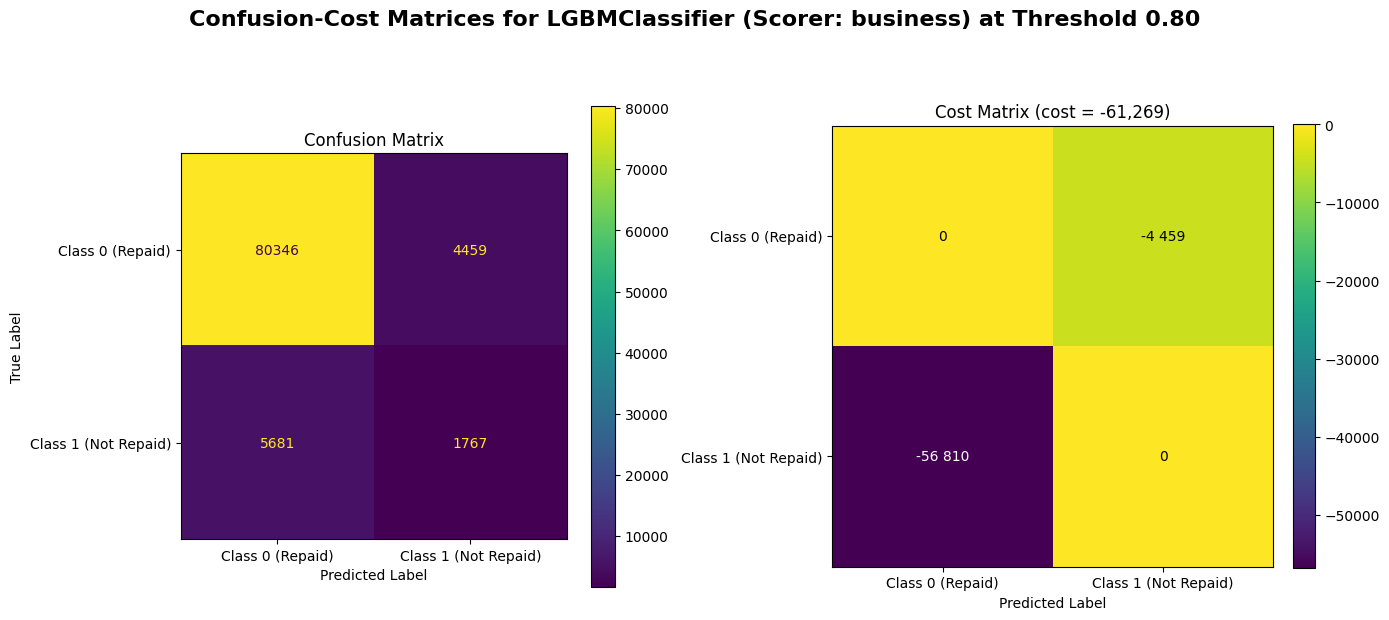

In [26]:
best_threshold = pipeline.threshold_evaluation_profit(fitted_model, X_test_processed, y_test)
pipeline.model_evaluation(fitted_model, X_test_processed, y_test, threshold = best_threshold, scorer = scorer, save_img = False, log_to_mlflow = False)

In [27]:
pipeline.get_results_df()

,Model,Scorer,Threshold,Precision,Recall,FNR,F2 Score,ROC-AUC,FN,FP,Cost,Profit,Business Cost Std
0,LGBMClassifier,business,0.41,0.135257,0.812701,0.187299,0.406002,0.752068,1395,38699,-52649,66040,0.710648
1,LGBMClassifier,business,0.50,0.156198,0.711869,0.288131,0.415934,0.752068,2146,28642,-50102,136570,0.668506
2,LGBMClassifier,business,0.80,0.283810,0.237245,0.762755,0.245294,0.752068,5681,4459,-61269,237000,0.197043


**CONCLUSION**

A compromise needs to be found between reducing the cost and maximizing the profit. To do so, we decided to see the difference in threshold for our model by trying to either max the profit or reduce the cost.
- While solely reducing the cost is interesting, it is done at the cost of precision and a lot of client that could repay their credit being classified as FP.
- Instead, maximizing the profit lead to much better results. While the rate of FN has increased somewhat we still have a much better

A decision needs to be made whether to focus ourselves on solely reducing the FN or maximzing the profit even at the cost of a higher FN count.

## Feature Importance

### Global

In [ ]:
print(fitted_model)

In [ ]:
import shap

# Sample a subset for efficiency
X_sampled = X_test_processed.sample(n=10000, random_state=42)


# Initialize the SHAP explainer USING THE MODERN API
explainer = shap.Explainer(fitted_model, X_sampled) # feature_perturbation="interventional"

# Compute SHAP values
shap_values = explainer.shap_values(X_sampled, check_additivity= False) # Returns a shap.Explanation object


# PS: I MIGHT HAVE BEEN USING LEGACY CODE INSTEAD OF MODERN SHAP...
# WARNING: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
#
# Should return a 3D array of shape (classes, rows, features) where each 2D slice represents the SHAP values for a specific class but it doesnt !!
# Instead, here i have a 2D array of shape (rows, features) for the positive class only !!

# WHY DOES LIGHTGBM DOES THIS ?
#
# This behavior is due to the way LightGBM computes predictions in binary classification.
# It focuses on the positive class probabilities (predict_proba[:, 1]) and uses log-odds (raw values) for optimization.
# The negative class is simply the complement, hence not explicitly returned.

# SOLUTION
# 1. Use the output for the positive class directly as the SHAP values for Class 1.
# 2. Negate the SHAP values for Class 1 to derive the SHAP values for Class 0.

# This approach works because the SHAP values for Class 0 and Class 1 are complementary: SHAP[0] = - SHAP[1]

# ==== IMPLEMENTATION ==== (USED IN BAR PLOT)
shap_values_True = shap_values # 2D array of the Positive class
shap_values_False = -shap_values_True # 2D array of the negative class derived from the Positive Class

# Combine both classes into a list
shap_values_combined = [shap_values_False, shap_values_True]



In [ ]:
# Create a new figure with a specified size
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height

# Generate the SHAP summary plot within the existing matplotlib axis
shap.summary_plot(
    shap_values=shap_values_combined,         # The SHAP values to visualize
    features=X_sampled,              # The dataset used for SHAP explanation
    plot_type="bar",                 # Plot type ('dot', 'violin', or 'bar')
    class_names=["Class 0: Repaid", "Class 1: Not Repaid"],
    max_display=15,                  # Maximum number of top features to display
    show=False                       # Prevent SHAP from automatically showing the plot
    )

# Add a custom title
plt.title("Global Feature Importance", fontsize=16)

# Adjust layout to prevent cropping
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
# Create a new figure with a specified size
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height

# Generate the SHAP summary plot within the existing matplotlib axis
shap.summary_plot(
    shap_values=shap_values,         # The SHAP values to visualize
    features=X_sampled,              # The dataset used for SHAP explanation
    plot_type="violin",                 # Plot type ('dot', 'violin', or 'bar')
    max_display=15,                  # Maximum number of top features to display
    show=False                       # Prevent SHAP from automatically showing the plot
    )

# Add a fitting title for the `dot` plot
plt.title("Feature Impact and Distribution", fontsize=16)

# Adjust layout to prevent cropping
plt.tight_layout()

# Display the plot
plt.show()


### Local

In [ ]:
import shap
import matplotlib.pyplot as plt

# Select an instance (e.g., first instance in X_sampled)
instance_index = 0  # Change this to select a different instance
features_instance = X_sampled.iloc[instance_index:instance_index + 1]  # Select a single instance as a DataFrame

# Compute SHAP values for the specific instance
shap_values_instance = explainer(features_instance)  # Compute SHAP values for the single instance

# Create a new figure with a specified size
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height

# Add a fitting title for the waterfall plot
plt.title("Local Feature Importance for Selected Instance", fontsize=16)

# Create a waterfall plot for the instance
shap.waterfall_plot(
    shap_values_instance[0],  # Access the explanation for the single instance
    max_display=15  # Limit the number of features shown in the plot
    )

# Adjust layout to prevent cropping
plt.tight_layout()

# Display the plot
plt.show()


## Data Drift

- Data Drift needs to be done on raw values !

Context:
- `application_train` represent the data for modelisation
- `application_test` represent new client data for the "mise en production"

In [ ]:
# REMEMBER WE DID THIS
# df_modelisation = df[df['TARGET'].notna()]      # The dataframe meant for Training & Testing
# df_predict = df[df['TARGET'].isna()]            # The dataframe meant for making real prediction on unclassified data

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# == DATADRIFT ==================================================================================
# Prepare reference data
reference_data = df_modelisation.drop(columns = ['TARGET'])     # Training data
current_data = df_predict                                       # New production data

# Create a Data Drift Report
data_drift_report = Report(metrics=[DataDriftPreset()])
data_drift_report.run(reference_data=reference_data, current_data=current_data)

# Save the report to HTML
data_drift_report.save_html('data_drift_report_raw.html')